In [1]:
from foundry.util.runtime import setup
setup()

import foundry.numpy as npx
import foundry.train.console
import foundry.train
import foundry.models
import foundry.diffusion.nonparametric as nonparametric

import matplotlib.pyplot as plt
import matplotlib as mpl
import optax
import jax
import flax.linen as nn

from collections.abc import Sequence
from functools import partial

from foundry.models.embed import SinusoidalPosEmbed
from foundry.models import activation

from foundry.random import PRNGSequence
from foundry.data import PyTreeData
from foundry.train import LossOutput
from foundry.diffusion.ddpm import DDPMSchedule
from foundry.core import tree

import seaborn as sns
sns.set_theme()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})

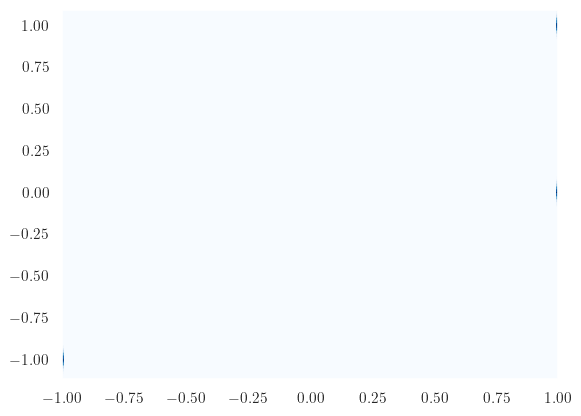

In [2]:
def sample(rng_key):
    m_rng, n_rng = foundry.random.split(rng_key, 2)
    z, x = foundry.random.choice(m_rng, npx.array([[-1., -1.],
                                                [1., 0.],
                                                [1., 1.]]))
    n_a, n_b = 0.03*foundry.random.normal(n_rng, (2,))
    z = z
    x = x + n_b
    return (z, x)

schedule = DDPMSchedule.make_squaredcos_cap_v2(
    64, 
    prediction_type="epsilon",
    clip_sample_range=2.
)


raw_data = jax.vmap(sample)(foundry.random.split(foundry.random.key(42), 10*1024))
data = PyTreeData(raw_data)
rng = PRNGSequence(42)

# plt.scatter(data.tree[0], data.tree[1])
plt.hist2d(data.tree[0], data.tree[1], bins=[256, 256], cmap='Blues')
plt.show()

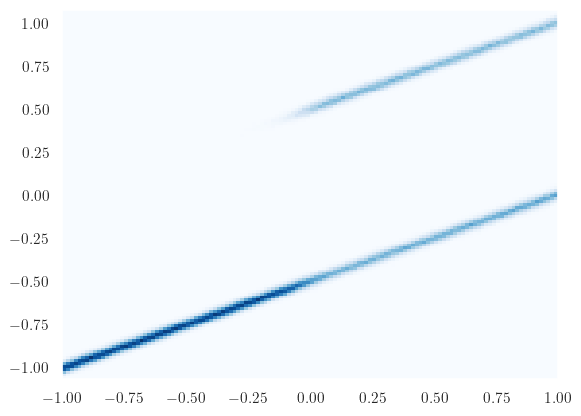

In [3]:
z = npx.linspace(-1, 1, 128)
rngs = foundry.random.split(foundry.random.key(42), z.shape[0])

def nw_diffuser(z, rng_key, x, t):
    # use transforms to correlate the kernels
    transform = lambda x, y: y - x/2
    inv_transform = lambda x, y_trans: y_trans + x/2
    return nonparametric.nw_cond_diffuser(z, raw_data, schedule, 
            nonparametric.log_gaussian_kernel, 0.3, 
            transform, inv_transform)(rng_key, x, t)

@jax.jit
def sample(z, rng_key):
    sampler = lambda rng_key: (z, schedule.sample(rng_key, partial(nw_diffuser, z), npx.zeros(())))
    zs, vs = jax.vmap(sampler)(foundry.random.split(rng_key, 2*1024))
    return zs, vs
zs, vs = jax.vmap(sample)(z, rngs)
zs, vs = npx.stack((zs, vs), -1).reshape(-1, 2).T
nw_samples = (zs, vs)

plt.hist2d(nw_samples[0], nw_samples[1], bins=[128, 128], cmap='Blues')
plt.show()

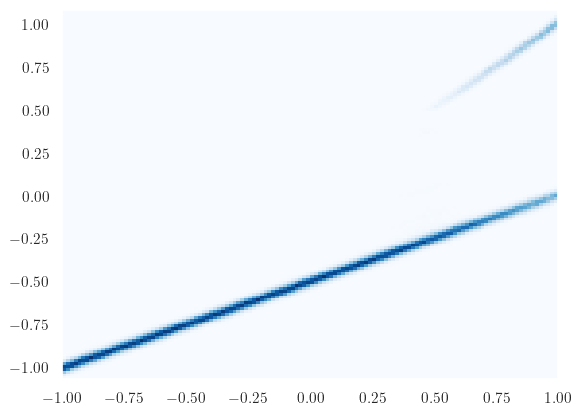

In [4]:
z = npx.linspace(-1, 1, 128)
rngs = foundry.random.split(foundry.random.key(42), z.shape[0])

def normal_denoiser(mu, sigma, x, t):
    # x_t = sqrt(alpha_t) x_0 + sqrt(1 - alpha_t) * N(0, 1)
    # E[x_0 | x_t] = integral x_0 p(x_0 | x_t) dx_0
    # = integral x_0 p(x_t | x_0) p(x_0) / p(x_t) dx_0
    # p(x_t) is a normalization constant
    # p(x_t | x_0) = N(x_t; sqrt(alpha_t) * x_0, 1 - alpha_t)
    # p(x_t | x_0) prop N(x_0; x_t/sqrt(alpha_t), (1 - alpha_t)/alpha_t)

    # E[x_0 | x_t] = (x_t/sqrt(alpha_t) * sigma^2 + mu * (1 - alpha_t) / alpha_t) / (sigma^2 + (1 - alpha_t) / alpha_t)
    # = (x_t * sqrt(alpha_t) * sigma^2 + mu * (1 - alpha_t)) / (sigma^2 * alpha_t + (1 - alpha_t))
    alpha_t = schedule.alphas_cumprod[t]
    sqrt_alpha_t = npx.sqrt(alpha_t)
    sigma_sqr = sigma**2
    denoised = (x*sqrt_alpha_t*sigma_sqr + mu*(1 - alpha_t)) / (sigma_sqr*alpha_t + (1 - alpha_t))

    # p(x_t) = N(x_t; sqrt(alpha_t) mu, alpha_t sigma^2) + N(x_t; 0, 1 - alpha_t)
    #  = N(x_t; sqrt(alpha_t) mu, alpha_t sigma^2 + 1 - alpha_t)
    log_pdf = -(x - sqrt_alpha_t*mu)**2 / (alpha_t*sigma_sqr + 1 - alpha_t)
    return denoised, log_pdf

def lin_nw_diffuser(z, rng_key, x, t):
    left_flow, _ = normal_denoiser(-1., 0.03, x, t)

    right_a, a_log_pdf = normal_denoiser(1., 0.03, x, t)
    right_b, b_log_pdf = normal_denoiser(0., 0.03, x, t)

    right_norm = npx.logaddexp(a_log_pdf, b_log_pdf)
    a_log_pdf = a_log_pdf - right_norm
    b_log_pdf = b_log_pdf - right_norm
    right_flow = npx.exp(a_log_pdf) * right_a + npx.exp(b_log_pdf) * right_b

    s = (z + 1)/2
    # s = (npx.sin(npx.pi/2 * z) + 1)/2
    denoised = (1  - s) * left_flow + s * right_flow
    return schedule.output_from_denoised(x, t, denoised)
@jax.jit
def sample(z, rng_key):
    sampler = lambda rng_key: (z, schedule.sample(rng_key, partial(lin_nw_diffuser, z), npx.zeros(()), eta=1.))
    zs, vs = jax.vmap(sampler)(foundry.random.split(rng_key, 2*1024))
    return zs, vs

zs, vs = jax.vmap(sample)(z, rngs)
zs, vs = npx.stack((zs, vs), -1).reshape(-1, 2).T
lin_nw_samples = (zs, vs)

plt.hist2d(lin_nw_samples[0], lin_nw_samples[1], bins=[128, 128], cmap='Blues')
plt.show()

In [5]:
class DiffusionMLP(nn.Module):
    features: Sequence[int] = (64, 64, 64)
    activation: str = "gelu"
    time_embed_dim: int = 64
    num_classes: int | None = None
    out_channels: int | None = None

    @nn.compact
    def __call__(self, x, t, cond=None, train=False):
        h = getattr(activation, self.activation)
        # works even if we have multiple timesteps
        embed = SinusoidalPosEmbed(self.time_embed_dim)(t)
        embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            h,
            nn.Dense(self.time_embed_dim),
        ])(embed)

        x, x_uf = tree.ravel_pytree(x)
        out_features = x.shape[-1]
        if cond is not None:
            cond, _ = tree.ravel_pytree(cond)
            x = npx.concatenate([x, cond], axis=-1)
        for feat in self.features:
            shift, scale = npx.split(nn.Dense(2*feat)(embed), 2, -1)
            x = h(nn.Dense(feat)(x))
            x = x * (1 + scale) + shift
        x = nn.Dense(out_features)(x)
        x = x_uf(x)
        return x


In [6]:
model = DiffusionMLP()

rng = PRNGSequence(0)
vars = model.init(next(rng), npx.zeros(()), 
    npx.zeros((), dtype=npx.uint32), cond=npx.zeros(()))

iterations = 10_000

optimizer = optax.adamw(optax.cosine_decay_schedule(1e-4, iterations), weight_decay=5e-4)
opt_state = optimizer.init(vars["params"])

@foundry.train.batch_loss
def loss(vars, rng_key, sample):
    z, x = sample
    loss = schedule.loss(rng_key, 
        lambda rng_key, x, t: model.apply(vars, x, t, cond=z),
        x
    )
    return LossOutput(
        loss=loss,
        metrics={"loss": loss}
    )

data_stream = data.stream().shuffle(next(rng)).batch(512)

with foundry.train.loop(data_stream,
    rng_key=next(rng), iterations=iterations
) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, vars, metrics = foundry.train.step(
                loss, optimizer, opt_state, vars, 
                step.rng_key, step.batch
            )
            if step.iteration % 1000 == 0:
                foundry.train.console.log(
                    step.iteration, metrics
                )
    foundry.train.console.log(
        step.iteration, metrics
    )

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10000/10000 100% 0:00:00 0:00:29
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500/500     100% 0:00:00 0:00:29
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20/20       100% 0:00:00 0:00:00


[13:55:52] INFO     foundry.train -      0 | loss: 1.3316822052001953
[13:55:56] INFO     foundry.train -   1000 | loss: 0.1698589026927948
[13:55:59] INFO     foundry.train -   2000 | loss: 0.14218004047870636
[13:56:02] INFO     foundry.train -   3000 | loss: 0.12496389448642731
[13:56:04] INFO     foundry.train -   4000 | loss: 0.14564554393291473
[13:56:07] INFO     foundry.train -   5000 | loss: 0.13945698738098145
[13:56:09] INFO     foundry.train -   6000 | loss: 0.13628995418548584
[13:56:12] INFO     foundry.train -   7000 | loss: 0.15333160758018494
[13:56:15] INFO     foundry.train -   8000 | loss: 0.13461634516716003
[13:56:18] INFO     foundry.train -   9000 | loss: 0.14081715047359467
[13:56:20] INFO     foundry.train -   9999 | loss: 0.15937072038650513


In [7]:
z = npx.linspace(-1, 1, 128)
rngs = foundry.random.split(foundry.random.key(42), z.shape[0])

nn_diffuser = lambda z, rng_key, x, t: model.apply(vars, x, t, cond=z)
@jax.jit
def sample(z, rng_key):
    sampler = lambda rng_key: (z, schedule.sample(rng_key, partial(nn_diffuser, z), npx.zeros(())))
    zs, vs = jax.vmap(sampler)(foundry.random.split(rng_key, 2*1024))
    return zs, vs
zs, vs = jax.vmap(sample)(z, rngs)
zs, vs = npx.stack((zs, vs), -1).reshape(-1, 2).T
nn_samples = (zs, vs)

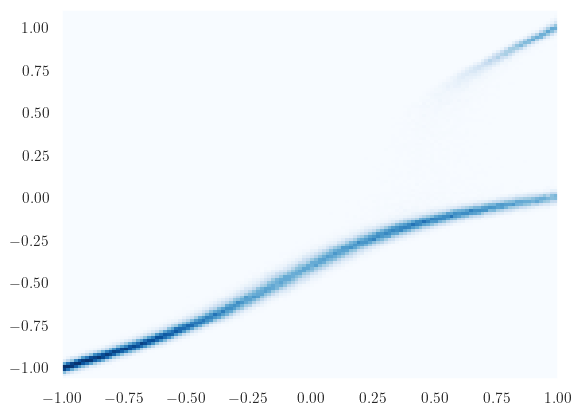

In [8]:
plt.hist2d(nn_samples[0], nn_samples[1], bins=[128, 128], cmap='Blues')
plt.show()

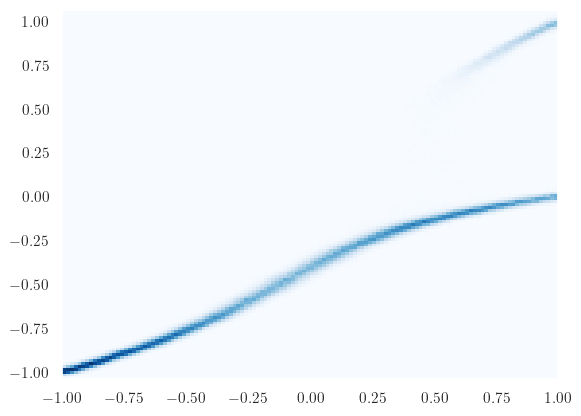

In [9]:
z = npx.linspace(-1, 1, 128)
rngs = foundry.random.split(foundry.random.key(42), z.shape[0])

def nn_nw_diffuser(z, rng_key, x, t):
    # use transforms to correlate the kernels
    return nonparametric.nw_cond_diffuser(z, nn_samples, schedule, 
            nonparametric.log_gaussian_kernel, 0.03)(rng_key, x, t)
@jax.jit
def sample(z, rng_key):
    sampler = lambda rng_key: (z, schedule.sample(rng_key, partial(nn_nw_diffuser, z), npx.zeros(())))
    zs, vs = jax.vmap(sampler)(foundry.random.split(rng_key, 2*1024))
    return zs, vs
zs, vs = jax.vmap(sample)(z, rngs)
zs, vs = npx.stack((zs, vs), -1).reshape(-1, 2).T
nn_nw_samples = (zs, vs)

plt.hist2d(nn_nw_samples[0], nn_nw_samples[1], bins=[128, 128], cmap='Blues')
plt.show()


In [10]:
z_cond = 0.75

n_samples = 16*1024

nw_cond_samples = jax.vmap(
    lambda r: schedule.sample(r, partial(nw_diffuser, z_cond), npx.zeros(()), eta=1.)
)(foundry.random.split(foundry.random.key(42), n_samples))
lin_nw_cond_samples = jax.vmap(
    lambda r: schedule.sample(r, partial(lin_nw_diffuser, z_cond), npx.zeros(()), eta=1.)
)(foundry.random.split(foundry.random.key(42), n_samples))
nn_cond_samples = jax.vmap(
    lambda r: schedule.sample(r, partial(nn_diffuser, z_cond), npx.zeros(()), eta=1.)
)(foundry.random.split(foundry.random.key(42), n_samples))
nn_nw_cond_samples = jax.vmap(
    lambda r: schedule.sample(r, partial(nn_nw_diffuser, z_cond), npx.zeros(()), eta=1.)
)(foundry.random.split(foundry.random.key(42), n_samples))

nw_trajectories = jax.vmap(
    lambda r: schedule.sample(r, partial(nw_diffuser, z_cond), npx.zeros(()), trajectory=True, eta=0)[1]
)(foundry.random.split(foundry.random.key(42), n_samples))
lin_nw_trajectories = jax.vmap(
    lambda r: schedule.sample(r, partial(lin_nw_diffuser, z_cond), npx.zeros(()), trajectory=True, eta=0)[1]
)(foundry.random.split(foundry.random.key(42), n_samples))
nn_trajectories = jax.vmap(
    lambda r: schedule.sample(r, partial(nn_diffuser, z_cond), npx.zeros(()), trajectory=True, eta=0)[1]
)(foundry.random.split(foundry.random.key(42), n_samples))
nn_nw_trajectories = jax.vmap(
    lambda r: schedule.sample(r, partial(nn_nw_diffuser, z_cond), npx.zeros(()), trajectory=True, eta=0)[1]
)(foundry.random.split(foundry.random.key(42), n_samples))
Ts = npx.arange(nw_trajectories.shape[-1])[None,:].repeat(nw_trajectories.shape[0], 0)

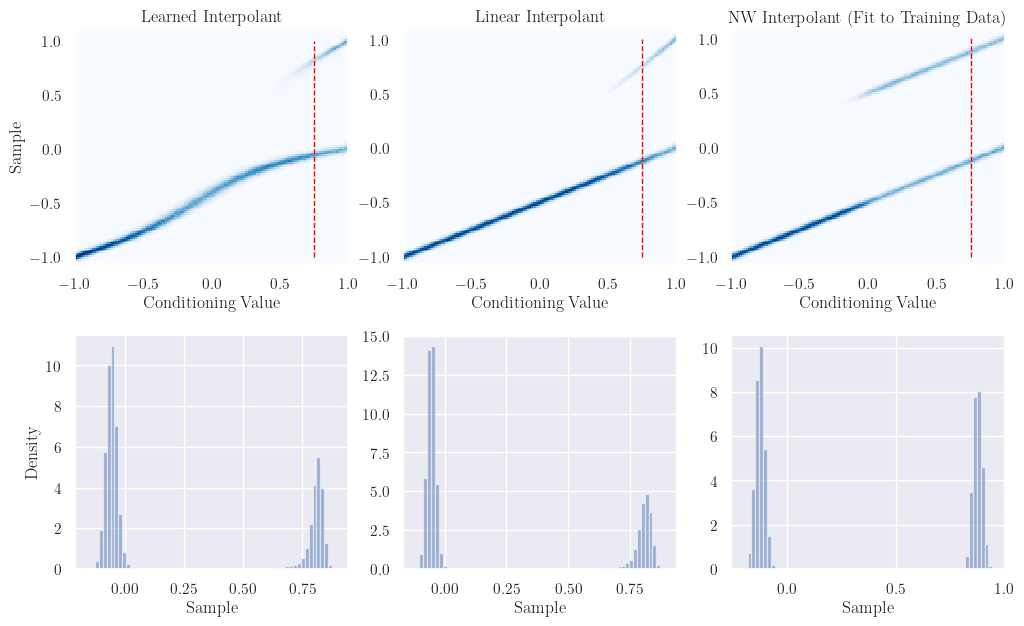

In [11]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7))

ax1.hist2d(nn_samples[0], nn_samples[1], bins=[128, 128], cmap='Blues')
ax1.set_title("Learned Interpolant")
ax2.hist2d(lin_nw_samples[0], lin_nw_samples[1], bins=[128, 128], cmap='Blues')
ax2.set_title("Linear Interpolant")
ax3.hist2d(nw_samples[0], nw_samples[1], bins=[128, 128], cmap='Blues')
ax3.set_title("NW Interpolant (Fit to Training Data)")

def plot_density(ax, samples):
    ax.hist(samples, bins=64, density=True, alpha=0.5)

plot_density(ax4, nn_cond_samples)
plot_density(ax5, nn_nw_cond_samples)
plot_density(ax6, nw_cond_samples)

ax1.set_ylabel("Sample")

ax1.set_xlabel("Conditioning Value")
ax2.set_xlabel("Conditioning Value")
ax3.set_xlabel("Conditioning Value")

ax1.add_line(plt.Line2D((0.75, 0.75), (-1, 1), color='red', linestyle="--", linewidth=1))
ax2.add_line(plt.Line2D((0.75, 0.75), (-1, 1), color='red', linestyle="--", linewidth=1))
ax3.add_line(plt.Line2D((0.75, 0.75), (-1, 1), color='red', linestyle="--", linewidth=1))

ax4.set_ylabel("Density")
ax4.set_xlabel("Sample")
ax5.set_xlabel("Sample")
ax6.set_xlabel("Sample")

fig.subplots_adjust(hspace=0.3)
fig.savefig("low_dim_comparison.pdf")
fig.show()

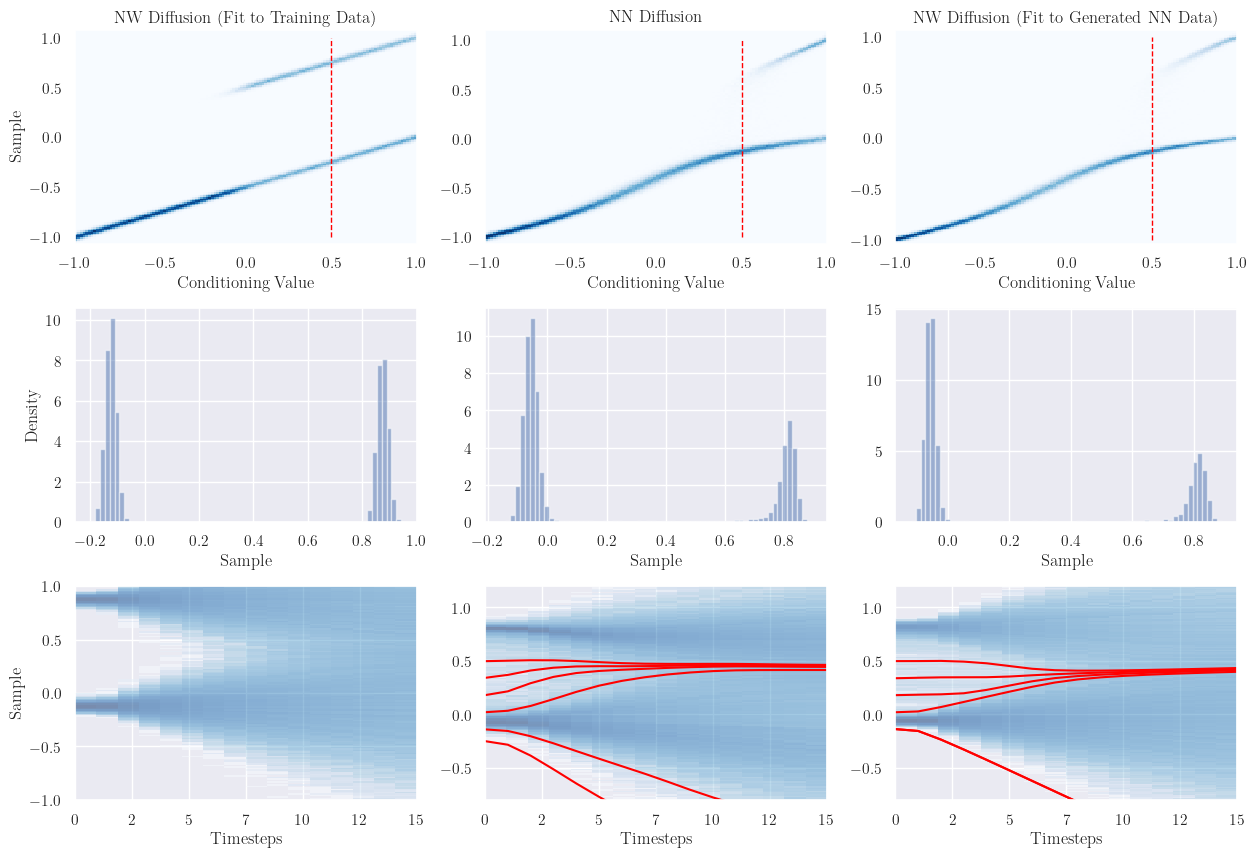

In [12]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 10))

ax1.hist2d(nw_samples[0], nw_samples[1], bins=[128, 128], cmap='Blues')
ax1.set_title("NW Diffusion (Fit to Training Data)")
ax2.hist2d(nn_samples[0], nn_samples[1], bins=[128, 128], cmap='Blues')
ax2.set_title("NN Diffusion")
ax3.hist2d(nn_nw_samples[0], nn_nw_samples[1], bins=[128, 128], cmap='Blues')
ax3.set_title("NW Diffusion (Fit to Generated NN Data)")

def plot_density(ax, samples):
    ax.hist(samples, bins=64, density=True, alpha=0.5)
    # res = scipy.stats.ecdf(samples)
    # xs = npx.linspace(-1, 1, 64)
    # cdfs = res.cdf.evaluate(xs)
    # locs = (xs[1:] + xs[:-1])/2
    # pdfs = (cdfs[1:] - cdfs[:-1])/(xs[1] - xs[0])
    # ax.plot(locs, pdfs)

plot_density(ax4, nw_cond_samples)
plot_density(ax5, nn_cond_samples)
plot_density(ax6, nn_nw_cond_samples)

def plot_hist(ax, traj):
    Ts = npx.arange(traj.shape[-1])[None,:].repeat(traj.shape[0], 0)
    traj = traj[:,:16]
    Ts = Ts[:,:16]
    ax.hist2d(Ts.reshape(-1), traj.reshape(-1), 
            norm=mpl.colors.LogNorm(), bins=[Ts.shape[1], 256], cmap="Blues", alpha=0.5)

def plot_hist_overlay(ax, trajectories, values=[]):
    trajectories = trajectories[:,:16]

    Ts = npx.arange(trajectories.shape[-1])[None,:].repeat(trajectories.shape[0], 0)

    ax.hist2d(Ts.reshape(-1), trajectories.reshape(-1), 
            norm=mpl.colors.LogNorm(), bins=[Ts.shape[1], 256], cmap="Blues", alpha=0.5)
    for v in values:
        i = npx.argmin(npx.abs(trajectories[:,0] - v))
        traj = trajectories[i]
        Ts = npx.arange(traj.shape[0])
        ax.plot(Ts, traj, color="red")

plot_hist(ax7, nw_trajectories)
plot_hist_overlay(ax8, nn_trajectories, npx.linspace(-0.3, 0.5, 6))
plot_hist_overlay(ax9, nn_nw_trajectories, npx.linspace(-0.3, 0.5, 6))
ax7.set_ylim(-1, 1)
ax8.set_ylim(-0.8, 1.2)
ax9.set_ylim(-0.8, 1.2)

ax1.set_ylabel("Sample")

ax1.set_xlabel("Conditioning Value")
ax2.set_xlabel("Conditioning Value")
ax3.set_xlabel("Conditioning Value")

ax1.add_line(plt.Line2D((0.5, 0.5), (-1, 1), color='red', linestyle="--", linewidth=1))
ax2.add_line(plt.Line2D((0.5, 0.5), (-1, 1), color='red', linestyle="--", linewidth=1))
ax3.add_line(plt.Line2D((0.5, 0.5), (-1, 1), color='red', linestyle="--", linewidth=1))

ax4.set_ylabel("Density")
ax4.set_xlabel("Sample")
ax5.set_xlabel("Sample")
ax6.set_xlabel("Sample")

ax7.set_xlabel("Timesteps")
ax8.set_xlabel("Timesteps")
ax9.set_xlabel("Timesteps")

ax7.set_ylabel("Sample")
ax7.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
ax8.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
ax9.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
fig.subplots_adjust(hspace=0.3)
# fig.savefig("low_dim_comparison.pdf")
fig.show()


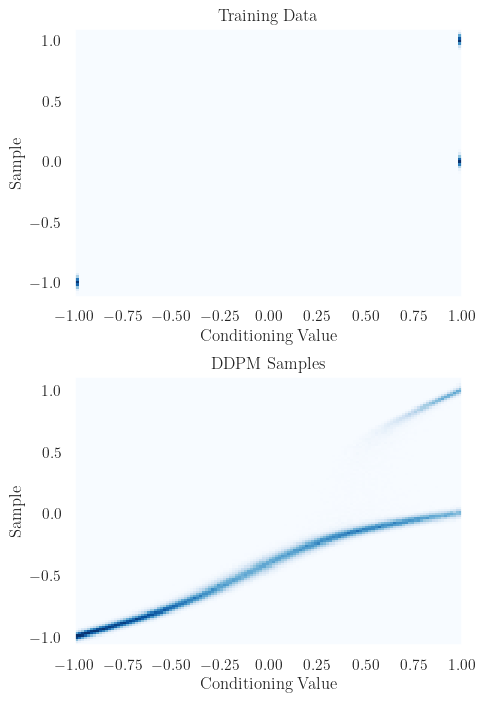

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist2d(raw_data[0], raw_data[1], bins=[100, 100], cmap='Blues')
ax2.hist2d(nn_samples[0], nn_samples[1], bins=[128, 128], cmap='Blues')

ax1.set_title("Training Data")
ax1.set_xlabel("Conditioning Value")
ax1.set_ylabel("Sample")

ax2.set_xlabel("Conditioning Value")
ax2.set_ylabel("Sample")
ax2.set_title("DDPM Samples")
fig.subplots_adjust(hspace=0.3)
fig.set_figwidth(5)
fig.set_figheight(8)
fig.savefig("nn_flow.pdf", bbox_inches='tight')
plt.show()